In [28]:
# importing dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
data_set_path = '/content/drive/MyDrive/ML&DL-projects/others/LSTM/AMZN.csv'

In [30]:
# Loading the data as pandas dataframe
import pandas as pd

data = pd.read_csv(data_set_path)
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [31]:
data.shape

(6516, 7)

In [32]:
# importing other important libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [33]:
data = data[['Date', 'Close']]
data.head(5)

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


In [34]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

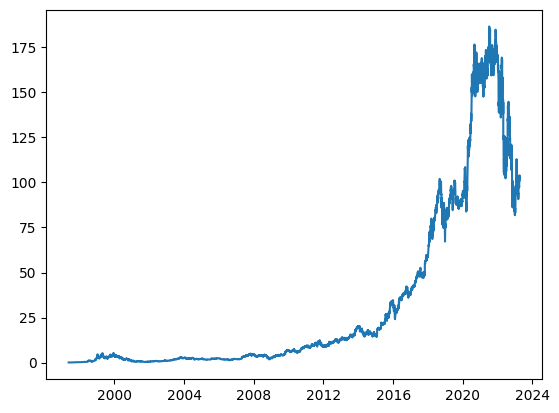

In [35]:
# Converting date to pandas-datetime-format
data.loc[:,'Date'] = pd.to_datetime(data['Date'])
# .loc[:, column] will take all the rows from the mentioned column

# Plotting the closing value with respect to time
plt.plot(data['Date'], data['Close'])
plt.show()

In [36]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [37]:
data.head(3)

,Date,Close
0,1997-05-15 00:00:00,0.097917
1,1997-05-16 00:00:00,0.086458
2,1997-05-19 00:00:00,0.085417


In [38]:
data.shift(1).head(3)

,Date,Close
0,None,NaN
1,1997-05-15 00:00:00,0.097917
2,1997-05-16 00:00:00,0.086458


In [39]:
# Converting data to numpy array
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [40]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

# Applying scaler
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [41]:
# Getting features and target data
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6509, 7), (6509,))

In [42]:
# Need to flip the axis, i.e., flip all the columns as
# the LSTM should see data from oldest to newest, i.e.,
# starting from (t-7) to (t-1)
X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [43]:
# Split index to split the data into train and test set
split_index = int(len(X) * 0.95)
split_index

6183

In [44]:
# Splitting the data into train and test set
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [45]:
# Adding batch dimention as we require this in pytorch
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [46]:
# Converting data to tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [47]:
# Generally we use datasets to train in pytorch ratherthen
# using raw tensors
# So create a custom dataset object

from torch.utils.data import Dataset

# Time series custom dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

# Creating the training and test dataset
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

len(train_dataset), len(test_dataset)

(6183, 326)

In [48]:
# Create dataloaders from our datasets
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [49]:
# For visualization checking one sample of train loader
for _, batch in enumerate(train_loader):
    X_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [50]:
# Creating LSTM model class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [51]:
# Training function

def train_one_epoch():
    # putting the model in train mode
    model.train(True)
    print(f"Epoch: {epoch+1}")
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        # putting the data to the correct device
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # forward pass
        output = model(X_batch)

        # Calculating loss
        loss = loss_fn(output, y_batch)
        running_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        if batch_index % 100 == 99: # print every 100 batchs
            avg_loss_across_batches = running_loss/100
            print('Batch: {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                     avg_loss_across_batches))
            running_loss = 0.0
    print()

In [52]:
# Validation function
def validate_one_epoch():
    # Putting the model into evaluation mode
    model.eval()

    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            # Running a forward pass
            output = model(X_batch)

            # Calculating loss
            loss = loss_fn(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss/len(test_loader)

    print("val_loss: {0:.3f}".format(avg_loss_across_batches))
    print("***************************************************")
    print()

In [53]:
# Training Loop

learning_rate = 0.001
num_epochs = 10
# As our model is basiclly solve a regression problem where
# a contenerous values are involved so we are trying to resuse the Mean Squared Error
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch: 100, Loss: 1.322
Batch: 200, Loss: 0.398
Batch: 300, Loss: 0.057

val_loss: 0.082
***************************************************

Epoch: 2
Batch: 100, Loss: 0.016
Batch: 200, Loss: 0.009
Batch: 300, Loss: 0.005

val_loss: 0.008
***************************************************

Epoch: 3
Batch: 100, Loss: 0.003
Batch: 200, Loss: 0.003
Batch: 300, Loss: 0.002

val_loss: 0.009
***************************************************

Epoch: 4
Batch: 100, Loss: 0.002
Batch: 200, Loss: 0.001
Batch: 300, Loss: 0.002

val_loss: 0.007
***************************************************

Epoch: 5
Batch: 100, Loss: 0.001
Batch: 200, Loss: 0.001
Batch: 300, Loss: 0.001

val_loss: 0.006
***************************************************

Epoch: 6
Batch: 100, Loss: 0.001
Batch: 200, Loss: 0.001
Batch: 300, Loss: 0.001

val_loss: 0.005
***************************************************

Epoch: 7
Batch: 100, Loss: 0.001
Batch: 200, Loss: 0.000
Batch: 300, Loss: 0.001

val_loss: 0.

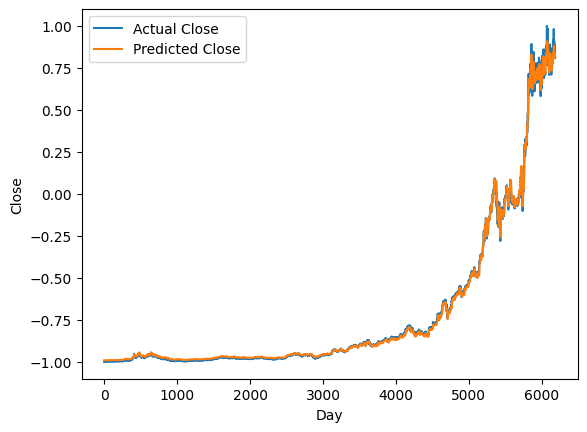

In [55]:
# Visualizing our predictions
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [56]:
# As our Close values are ranged from -1 to 1 it is not much use to us.
# So, Converting the scaled Close values to normal values

# Flatten the the predicted data
train_predictions = predicted.flatten()

# Creating a zero matrix having 1st column and added time series columns
dummies = np.zeros((X_train.shape[0], lookback+1))
# copying train_prediction data to the first column keeping other columns zero
dummies[:, 0] = train_predictions
# Applying inverse transform
dummies = scaler.inverse_transform(dummies)

# Getting a deep copy of the dummies
train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.96921467,   0.96928136,   0.9691035 , ..., 169.78021766,
       168.94392022, 169.2234827 ])

In [57]:
# Applying similar inverse transform for y_train
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

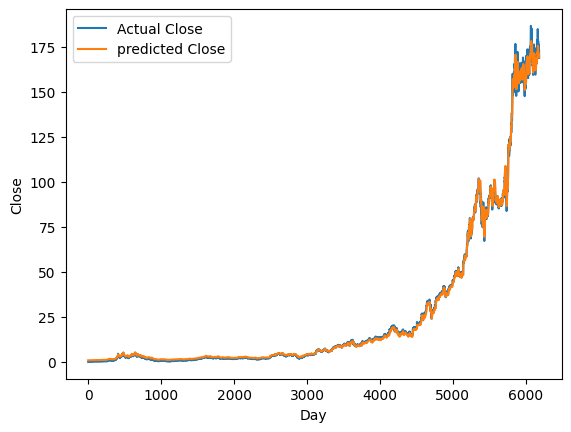

In [58]:
plt.plot(new_y_train, label="Actual Close")
plt.plot(train_predictions, label="predicted Close")

plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()

In [60]:
# Getting the test data for visualization

# Run the model in target device to get the output
# then detach and take the data back to cpu and convert to numpy then flattnen the data
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

# Create dummies to perform inverse transform
# the shape of dummies = (X_test.shape[0]) X (lookback+1)
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions[:5]

array([168.48496377, 168.21979683, 167.3995068 , 167.5709082 ,
       167.89837057])

In [63]:
# Getting the ground truth to proper scale
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test[: 5]

array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 ])

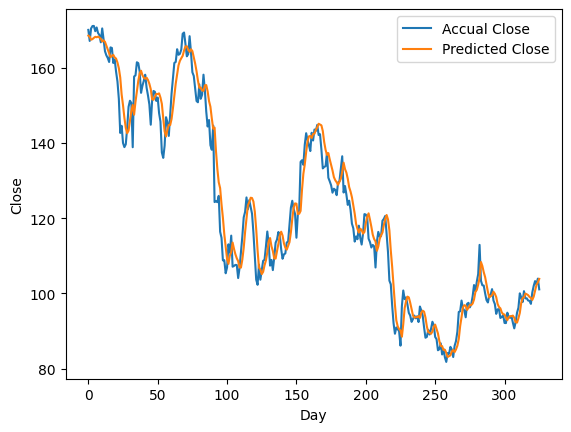

In [64]:
# Visualizing the test data
plt.plot(new_y_test, label="Accual Close")
plt.plot(test_predictions, label="Predicted Close")

plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()